In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import implementPairDecayLimit, fromHB5Table2
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 8TeV LHC

## `H>aa>mumu` ultra light [1506.00424](https://arxiv.org/abs/1506.00424)


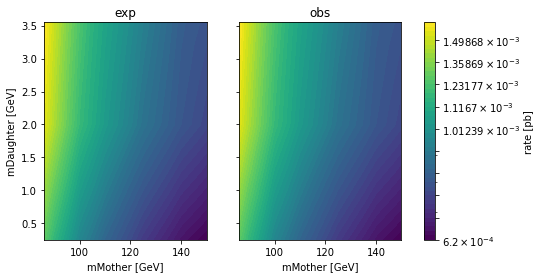

Looks good. Saving this to H_LHC8_CMS_21.json


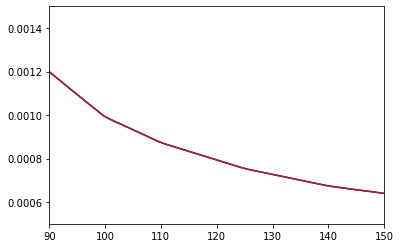

In [2]:
aMasses = [0.25, 2, 3.55]  # these are the only ones given in the paper
df = fromHB5Table2("150600424_CMS_H-aa-mumu", "CMS", manuallySelectedM2=aMasses)
# fb to pb
df.obs /= 1e3
df.exp /= 1e3
limitFile = implementPairDecayLimit(
    "1506.00424",
    {
        "production": ["H"],
        "firstDecay": ["mumu"],
        "secondDecay": ["mumu"],
    },
    "Fig. 2 (left)",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["veryLight"],  # original source for this
        "secondDaughter": resolution.mumu["veryLight"],
        "mother": {"absolute": 2, "relative": 0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("mumu", 1.0)
h1.setMass(0.5)
hm = np.linspace(90, 150)
r = np.linspace(5e-4, 1.5e-3)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
